# <b>Assignment : DT</b>

# <font color='red'> <b>Task - 1</b></font>

<ol>
    <li><strong>Apply Decision Tree Classifier(DecisionTreeClassifier) on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical, numerical features +  preprocessed_essay (TFIDF) + Sentiment scores(preprocessed_essay)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features +  preprocessed_essay (TFIDF W2V) + Sentiment scores(preprocessed_essay)</li>        </ul>
    </li>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation(use gridsearch cv or randomsearch cv)/simple cross validation data(you can write your own for loops refer sample solution)</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>min_sample_split</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>min_sample_split</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
    <li>Once after you plot the confusion matrix with the test data, get all the `false positive data points`
        <ul>
            <li> Plot the WordCloud(https://www.geeksforgeeks.org/generating-word-cloud-python/) with the words of essay text of these `false positive data points`</li>
            <li> Plot the box plot with the `price` of these `false positive data points`</li>
            <li> Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data points`</li>
        </ul>
        </ul>
    </li>
   

In [52]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

!pip install chart_studio
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os
from sklearn import preprocessing

import chart_studio.plotly as plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

import nltk
nltk.download('vader_lexicon')

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer


sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


##Apply Decision Tree Classifier(DecisionTreeClassifier) on these feature set1

In [60]:
data  = pd.read_csv('preprocessed_data2.csv', nrows=50000)
data.head(5)

teacher_prefix  ...   price
0            mrs  ...  154.60
1             mr  ...  299.00
2             ms  ...  516.85
3            mrs  ...  232.90
4            mrs  ...   67.98

[5 rows x 11 columns]

In [61]:
print("Number of data points in train data", data.shape)
print('-'*50)
print("The attributes of data :", data.columns.values)

Number of data points in train data (50000, 11)
--------------------------------------------------
The attributes of data : ['teacher_prefix' 'school_state' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved'
 'essay' 'price']


In [62]:
# check if we have any nan values are there
print(data['project_title'].isnull().values.any())
print("number of nan values",data['project_title'].isnull().values.sum())

False
number of nan values 0


In [63]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)
X.head(1)

teacher_prefix  ...  price
0            mrs  ...  154.6

[1 rows x 10 columns]

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [64]:
# train test split
from sklearn.model_selection import train_test_split
index = np.arange(len(X))
X_train, X_test, y_train, y_test,ix ,iy  = train_test_split(X, y,index, test_size=0.33, stratify=y)

<h2>1.3 Make Data Model Ready: encoding essay on tfidf vectorizer</h2>

In [65]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("="*100)

vectorizer_1 = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer_1.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer_1.transform(X_train['essay'].values)
X_test_essay_tfidf = vectorizer_1.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("="*100)

(33500, 10) (33500,)
(16500, 10) (16500,)
After vectorizations
(33500, 5000) (33500,)
(16500, 5000) (16500,)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

<h3>1.4.1 encoding categorical features: School State</h3>

In [66]:
vectorizer_2 = CountVectorizer()
vectorizer_2.fit(X_train['school_state'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer_2.transform(X_train['school_state'].values)
X_test_state_ohe = vectorizer_2.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_test_state_ohe.shape, y_test.shape)

After vectorizations
(33500, 51) (33500,)
(16500, 51) (16500,)


<h3>1.4.2 encoding categorical features: teacher_prefix</h3>

In [67]:
vectorizer_3 = CountVectorizer()
vectorizer_3.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer_3.transform(X_train['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer_3.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)
print(X_test_teacher_ohe.shape, y_test.shape)

After vectorizations
(33500, 5) (33500,)
(16500, 5) (16500,)


<h3>1.4.3 encoding categorical features: project_grade_category</h3>

In [68]:
vectorizer_4 = CountVectorizer()
vectorizer_4.fit(X_train['project_grade_category'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer_4.transform(X_train['project_grade_category'].values)
X_test_grade_ohe = vectorizer_4.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)
print(X_test_grade_ohe.shape, y_test.shape)

After vectorizations
(33500, 4) (33500,)
(16500, 4) (16500,)


<h3>1.4.4 encoding categorical features: project_subject_categories</h3>

In [69]:
vectorizer_5 = CountVectorizer()
vectorizer_5.fit(X_train['project_subject_categories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_subject_categories = vectorizer_5.transform(X_train['project_subject_categories'].values)
X_test_subject_categories = vectorizer_5.transform(X_test['project_subject_categories'].values)

print("After vectorizations")
print(X_train_subject_categories.shape, y_train.shape)
print(X_test_subject_categories.shape, y_test.shape)

After vectorizations
(33500, 50) (33500,)
(16500, 50) (16500,)


<h3>1.4.5 encoding categorical features: project_subject_subcategories</h3>

In [70]:

vectorizer_6 = CountVectorizer(max_features=100)
vectorizer_6.fit(X_train['project_subject_subcategories'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_subject_subcategories = vectorizer_6.transform(X_train['project_subject_subcategories'].values)
X_test_subject_subcategories = vectorizer_6.transform(X_test['project_subject_subcategories'].values)

print("After vectorizations")
print(X_train_subject_subcategories.shape, y_train.shape)
print(X_test_subject_subcategories.shape, y_test.shape)

After vectorizations
(33500, 100) (33500,)
(16500, 100) (16500,)


<h3>1.4.6 encoding numerical features: Price</h3>

In [71]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1))



print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(1, 33500) (33500,)
(1, 16500) (16500,)


In [72]:
#we are defining this function to return arrray
def to_array(a):
  b = a.tolist()
  c = []
  for i in b:
    for  j in i:
      c.append(j)
  d = [i for i in range(len(c))]
  df = pd.DataFrame(list(zip(d, c)),columns = ['1','2'])  
  e = df.drop(['1'], axis=1)
  array = e.to_numpy()  

  return array  

In [73]:
X_train_price_norm_array = to_array(X_train_price_norm) 
X_test_price_norm_array = to_array(X_test_price_norm)

In [74]:
def to_array1(a):
  d = [i for i in range(len(a))]
  df = pd.DataFrame(list(zip(d, a)),columns = ['1','2'])  
  e = df.drop(['1'], axis=1)
  array = e.to_numpy()  

  return array  


def sentiment(X):
  neg, neu, pos, compound = list(), list(), list(), list()
  for i, row in X.iterrows():
    ss = sid.polarity_scores(row['essay'])
    neg.append(ss['neg'])
    neu.append(ss['neu'])
    pos.append(ss['pos'])
    compound.append(ss['compound'])
  
  neg_array = to_array1(neg)  
  neu_array = to_array1(neu) 
  pos_array = to_array1(pos) 
  compound_array = to_array1(compound)

  return  neg_array,neu_array,pos_array,compound_array


In [75]:
X_train_neg,X_train_neu,X_train_pos,X_train_compound = sentiment(X_train)
X_test_neg,X_test_neu,X_test_pos,X_test_compound = sentiment(X_test)

### 1.4.7 Concatinating all the features

In [76]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((X_train_essay_tfidf,X_train_state_ohe,X_train_subject_categories,X_train_subject_subcategories, X_train_teacher_ohe, X_train_grade_ohe)).tocsr()
X_te = hstack((X_test_essay_tfidf,X_test_state_ohe,X_test_subject_categories,X_test_subject_subcategories, X_test_teacher_ohe, X_test_grade_ohe)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(33500, 5210) (33500,)
(16500, 5210) (16500,)


In [77]:
X_tr1 = X_tr.toarray()
#Normalize Data
X_tr1 = preprocessing.normalize(X_tr1)
X_train_neg = preprocessing.normalize(X_train_neg)
X_train_neu = preprocessing.normalize(X_train_neu)
X_train_pos = preprocessing.normalize(X_train_pos)
X_train_compound = preprocessing.normalize(X_train_compound)
X_tr2 = np.concatenate((X_tr1, X_train_price_norm_array,X_train_neg,X_train_neu,X_train_pos,X_train_compound), axis=1)



X_te1 = X_te.toarray()
#Normalize Data
X_te1 = preprocessing.normalize(X_te1)
X_test_neg = preprocessing.normalize(X_test_neg)
X_test_neu = preprocessing.normalize(X_test_neu)
X_test_pos = preprocessing.normalize(X_test_pos)
X_test_compound = preprocessing.normalize(X_test_compound)
X_te2 = np.concatenate((X_te1, X_test_price_norm_array,X_test_neg,X_test_neu,X_test_pos,X_test_compound), axis=1)

In [78]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

In [79]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
clf_Dtree = DecisionTreeClassifier()
param_grid= {'max_depth': [1, 5, 10, 50],'min_samples_split': [5, 10, 100, 500]}
GridSearch_Dtree = GridSearchCV(clf_Dtree,param_grid,cv=3,scoring='roc_auc', return_train_score=True)
GridSearch_Dtree.fit(X_tr2, y_train)
print(GridSearch_Dtree.best_estimator_)
print("Best HyperParameter: ",GridSearch_Dtree.best_params_)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Best HyperParameter:  {'max_depth': 10, 'min_samples_split': 500}


Text(0.5, 1.0, 'Train Score')

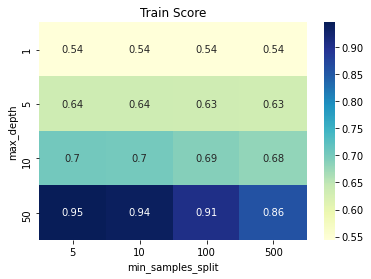

In [ ]:
Train_mean = GridSearch_Dtree.cv_results_['mean_train_score']

X = [1,1,1,1,5,5,5,5,10,10,10,10,50,50,50,50]
Y = [5, 10, 100, 500,5, 10, 100, 500,5, 10, 100, 500,5, 10, 100, 500]


df = pd.DataFrame(list(zip(X,Y,Train_mean)), 
               columns =['max_depth', 'min_samples_split', 'Train_mean']) 
plot_data = df.pivot("max_depth", "min_samples_split", "Train_mean")
ax = sns.heatmap(plot_data, annot=True, cmap="YlGnBu")
ax.set_title('Train Score')

Text(0.5, 1.0, 'cross_validation Score')

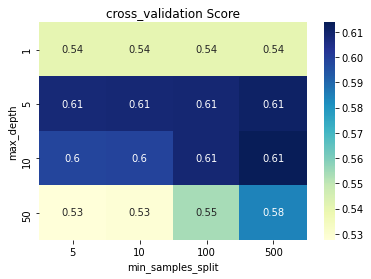

In [ ]:
CV_mean = GridSearch_Dtree.cv_results_['mean_test_score']
    
df = pd.DataFrame(list(zip(X,Y,CV_mean)), 
               columns =['max_depth', 'min_samples_split', 'CV_mean']) 
plot_data = df.pivot("max_depth", "min_samples_split", "CV_mean")
ax = sns.heatmap(plot_data, annot=True, cmap="YlGnBu")
ax.set_title('cross_validation Score')

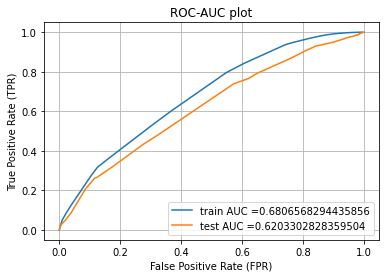

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

clf_Dtree = DecisionTreeClassifier(max_depth= 10, min_samples_split= 500)
#neigh = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
clf_Dtree.fit(X_tr2, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(clf_Dtree, X_tr2)    
y_test_pred = batch_predict(clf_Dtree, X_te2)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC-AUC plot")
plt.grid()
plt.show()

In [26]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

def Confusion_matrix(y_test, test_pred):
  # Confusion matrix for test data
  plt.figure()
  cm = confusion_matrix(y_test, test_pred)
  class_label = ["negative", "positive"]
  df_cm_test = pd.DataFrame(cm, index = class_label, columns = class_label)
  sns.heatmap(df_cm_test , annot = True, fmt = "d")
  plt.title("Confusiion Matrix for test data")
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()    

the maximum value of tpr*(1-fpr) 0.38031538854423597 for threshold 0.863
Test confusion matrix


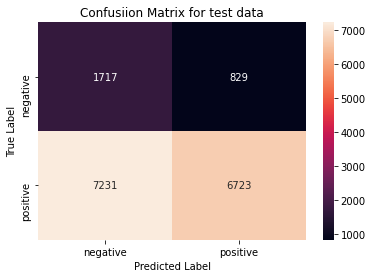

In [ ]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Test confusion matrix")
Confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

In [ ]:
y_test_pred = predict_with_best_t(y_test_pred, best_t)
indices = []
for i in range(len(y_test)):
  if (y_test[i] == 0) and (y_test_pred[i] == 1):
    indices.append(iy[i])


df = [X_test['essay'][i] for i in indices]

new_x = X.iloc[indices]



In [44]:
!pip install wordcloud

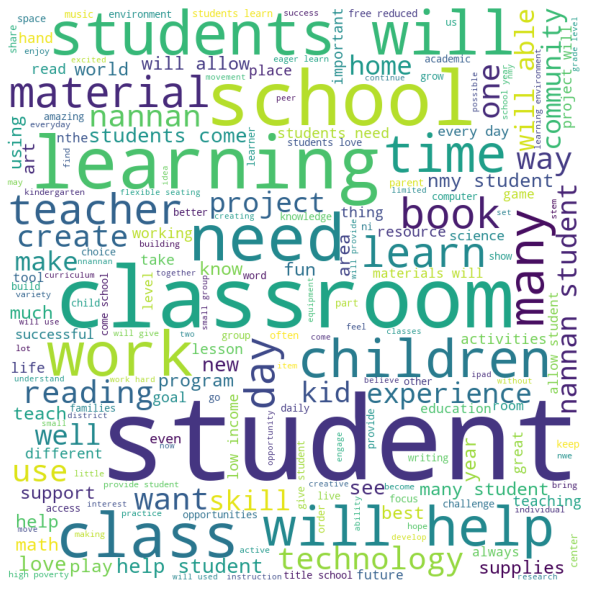

In [ ]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

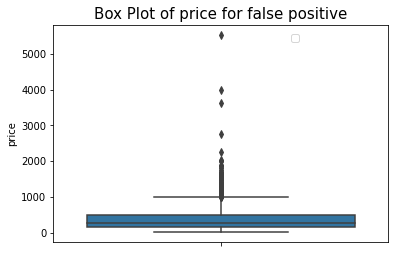

In [ ]:
import warnings
warnings.filterwarnings('ignore')
plt.title("Box Plot of price for false positive",fontsize=15)
ax=sns.boxplot(y='price', data=new_x)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper right', ncol=2, bbox_to_anchor=(.75, 0.98))
plt.show()

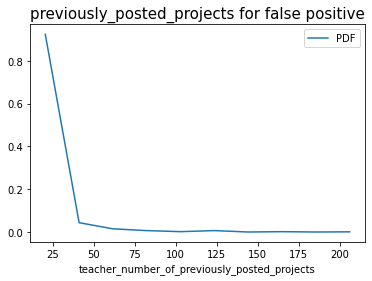

In [ ]:
counts, bin_edges = np.histogram(new_x['teacher_number_of_previously_posted_projects'], bins=10, 
                                 density = True)
pdf = counts/(sum(counts))
plt.plot(bin_edges[1:],pdf);
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.title("previously_posted_projects for false positive",fontsize=15)
plt.legend(['PDF'])
plt.show();

##Apply Decision Tree Classifier(DecisionTreeClassifier) on these feature set2

<h2>1.3 Make Data Model Ready: encoding essay on TFIDF weighted W2V</h2>

In [27]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [28]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['essay'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [29]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_X_train = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_X_train.append(vector)

print(len(tfidf_w2v_vectors_X_train))
print(len(tfidf_w2v_vectors_X_train[0]))

100%|██████████| 33500/33500 [02:13<00:00, 250.11it/s]

33500
300


In [30]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_X_test = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_X_test.append(vector)

print(len(tfidf_w2v_vectors_X_test))
print(len(tfidf_w2v_vectors_X_test[0]))

100%|██████████| 16500/16500 [01:06<00:00, 249.93it/s]

16500
300


### 1.4.7 Concatinating all the features


In [31]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X_tr = hstack((tfidf_w2v_vectors_X_train,X_train_state_ohe,X_train_subject_categories,X_train_subject_subcategories, X_train_teacher_ohe, X_train_grade_ohe)).tocsr()
X_te = hstack((tfidf_w2v_vectors_X_test,X_test_state_ohe,X_test_subject_categories,X_test_subject_subcategories, X_test_teacher_ohe, X_test_grade_ohe)).tocsr()

print("Final Data matrix")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)
print("="*100)

Final Data matrix
(33500, 509) (33500,)
(16500, 509) (16500,)


In [32]:
X_tr1 = X_tr.toarray()
#Normalize Data
X_tr1 = preprocessing.normalize(X_tr1)
X_train_neg = preprocessing.normalize(X_train_neg)
X_train_neu = preprocessing.normalize(X_train_neu)
X_train_pos = preprocessing.normalize(X_train_pos)
X_train_compound = preprocessing.normalize(X_train_compound)
X_tr2 = np.concatenate((X_tr1, X_train_price_norm_array,X_train_neg,X_train_neu,X_train_pos,X_train_compound), axis=1)

In [33]:
X_te1 = X_te.toarray()
#Normalize Data
X_te1 = preprocessing.normalize(X_te1)
X_test_neg = preprocessing.normalize(X_test_neg)
X_test_neu = preprocessing.normalize(X_test_neu)
X_test_pos = preprocessing.normalize(X_test_pos)
X_test_compound = preprocessing.normalize(X_test_compound)
X_te2 = np.concatenate((X_te1, X_test_price_norm_array,X_test_neg,X_test_neu,X_test_pos,X_test_compound), axis=1)

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
clf_Dtree = DecisionTreeClassifier()
param_grid= {'max_depth': [1, 5, 10, 50],'min_samples_split': [5, 10, 100, 500]}
GridSearch_Dtree = GridSearchCV(clf_Dtree,param_grid,cv=3,scoring='roc_auc', return_train_score=True)
GridSearch_Dtree.fit(X_tr2, y_train)
print(GridSearch_Dtree.best_estimator_)
print("Best HyperParameter: ",GridSearch_Dtree.best_params_)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Best HyperParameter:  {'max_depth': 10, 'min_samples_split': 500}


Text(0.5, 1.0, 'Train Score')

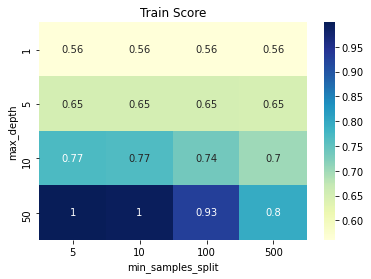

In [35]:
Train_mean = GridSearch_Dtree.cv_results_['mean_train_score']

X = [1,1,1,1,5,5,5,5,10,10,10,10,50,50,50,50]
Y = [5, 10, 100, 500,5, 10, 100, 500,5, 10, 100, 500,5, 10, 100, 500]


df = pd.DataFrame(list(zip(X,Y,Train_mean)), 
               columns =['max_depth', 'min_samples_split', 'Train_mean']) 
plot_data = df.pivot("max_depth", "min_samples_split", "Train_mean")
ax = sns.heatmap(plot_data, annot=True, cmap="YlGnBu")
ax.set_title('Train Score')

Text(0.5, 1.0, 'cross_validation Score')

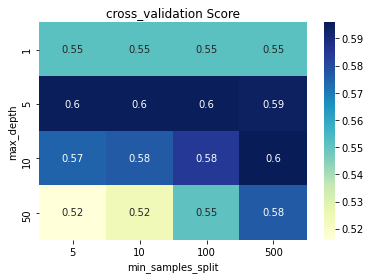

In [36]:
CV_mean = GridSearch_Dtree.cv_results_['mean_test_score']
    
df = pd.DataFrame(list(zip(X,Y,CV_mean)), 
               columns =['max_depth', 'min_samples_split', 'CV_mean']) 
plot_data = df.pivot("max_depth", "min_samples_split", "CV_mean")
ax = sns.heatmap(plot_data, annot=True, cmap="YlGnBu")
ax.set_title('cross_validation Score')

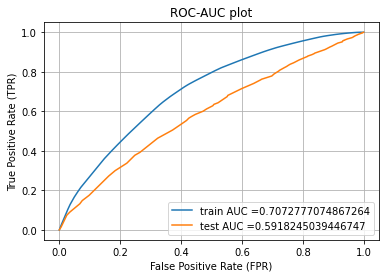

In [37]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

clf_Dtree = DecisionTreeClassifier(max_depth= 10, min_samples_split= 500)
#neigh = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
clf_Dtree.fit(X_tr2, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(clf_Dtree, X_tr2)    
y_test_pred = batch_predict(clf_Dtree, X_te2)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC-AUC plot")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.42881758677188525 for threshold 0.863
Test confusion matrix


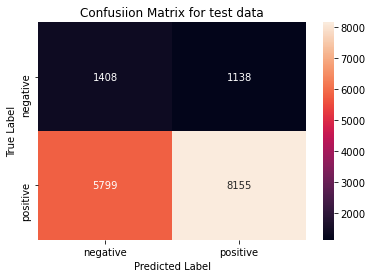

In [38]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Test confusion matrix")
Confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

In [43]:
y_test_pred = predict_with_best_t(y_test_pred, best_t)
indices = []
for i in range(len(y_test)):
  if (y_test[i] == 0) and (y_test_pred[i] == 1):
    indices.append(iy[i])


df = [X_test['essay'][i] for i in indices]

new_x = X.iloc[indices]

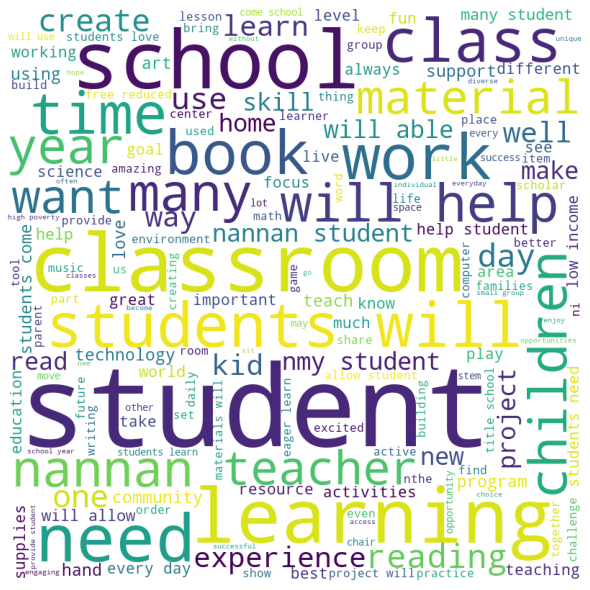

In [45]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

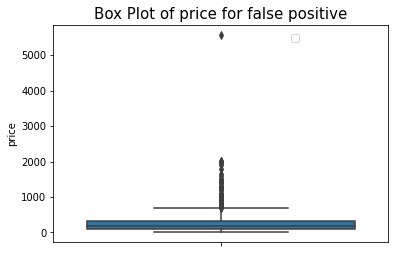

In [46]:
import warnings
warnings.filterwarnings('ignore')
plt.title("Box Plot of price for false positive",fontsize=15)
ax=sns.boxplot(y='price', data=new_x)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper right', ncol=2, bbox_to_anchor=(.75, 0.98))
plt.show()

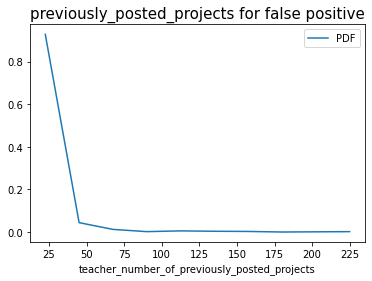

In [47]:
counts, bin_edges = np.histogram(new_x['teacher_number_of_previously_posted_projects'], bins=10, 
                                 density = True)
pdf = counts/(sum(counts))
plt.plot(bin_edges[1:],pdf);
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.title("previously_posted_projects for false positive",fontsize=15)
plt.legend(['PDF'])
plt.show();

# <font color='red'><b> Task - 2 </b></font>

For this task consider **set-1** features.

*  Select all the features which are having non-zero feature importance.You can get the feature importance using  'feature_importances_` 
   (https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html), discard the all other remaining features and then apply any of the model of you choice i.e. (Dession tree, Logistic Regression, Linear SVM).
*  You need to do hyperparameter tuning corresponding to the model you selected and procedure in step 2 and step 3<br>
  **Note**: when you want to find the feature importance make sure you don't use max_depth parameter keep it None.
  </li>
    <br>
You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<font color='blue'><b>Hint for calculating Sentiment scores</b></font>

In [81]:
list_vectorizer = [vectorizer_1,vectorizer_2,vectorizer_3,vectorizer_4,vectorizer_5,vectorizer_6]
def features_import(transform,X_train,y_train,optimal_min_samples_split):
  feature_name = []
  for i in transform:
    feature_name.extend(i.get_feature_names())

  feature_name.append('price') 
  feature_name.append('neg') 
  feature_name.append('neu') 
  feature_name.append('pos') 
  feature_name.append('compound') 

  feature_dtree = DecisionTreeClassifier(min_samples_split = optimal_min_samples_split)
  feature_dtree.fit(X_train, y_train)

  feature_value = feature_dtree.feature_importances_

  feature_table = pd.DataFrame(feature_value, columns = feature_name)

  return feature_table


In [82]:
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

list_vectorizer = [vectorizer_1,vectorizer_2,vectorizer_3,vectorizer_4,vectorizer_5,vectorizer_6]
feature_name = []
for i in list_vectorizer:
  feature_name.extend(i.get_feature_names())
feature_name.append('price') 
feature_name.append('neg') 
feature_name.append('neu') 
feature_name.append('pos') 
feature_name.append('compound')

feature_dtree = DecisionTreeClassifier(min_samples_split = 500)
feature_dtree.fit(X_tr2, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [84]:
feature_value = feature_dtree.feature_importances_
feature_value = feature_value.tolist()

non_zero_indices = []
for i, j in enumerate(feature_value):
  if j >0:
    non_zero_indices.append(i)

imp_feat = []
for i in non_zero_indices:
  imp_feat.append(feature_name[i])


x_train = X_tr2[:,non_zero_indices]  
x_test = X_te2[:,non_zero_indices]
   

In [ ]:
from sklearn.model_selection import GridSearchCV
clf_Dtree = DecisionTreeClassifier()
param_grid= {'max_depth': [1, 5, 10, 50],'min_samples_split': [5, 10, 100, 500]}
GridSearch_Dtree = GridSearchCV(clf_Dtree,param_grid,cv=3,scoring='roc_auc', return_train_score=True)
GridSearch_Dtree.fit(x_train, y_train)
print(GridSearch_Dtree.best_estimator_)
print("Best HyperParameter: ",GridSearch_Dtree.best_params_)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=500,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Best HyperParameter:  {'max_depth': 10, 'min_samples_split': 500}


Text(0.5, 1.0, 'Train Score')

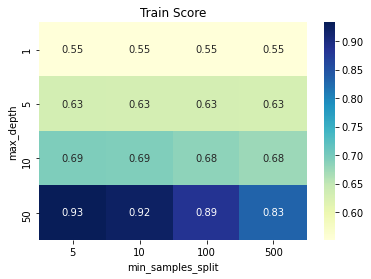

In [ ]:
Train_mean = GridSearch_Dtree.cv_results_['mean_train_score']

X = [1,1,1,1,5,5,5,5,10,10,10,10,50,50,50,50]
Y = [5, 10, 100, 500,5, 10, 100, 500,5, 10, 100, 500,5, 10, 100, 500]


df = pd.DataFrame(list(zip(X,Y,Train_mean)), 
               columns =['max_depth', 'min_samples_split', 'Train_mean']) 
plot_data = df.pivot("max_depth", "min_samples_split", "Train_mean")
ax = sns.heatmap(plot_data, annot=True, cmap="YlGnBu")
ax.set_title('Train Score')

Text(0.5, 1.0, 'cross_validation Score')

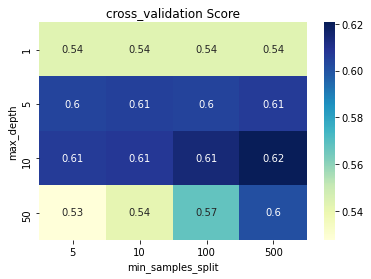

In [ ]:
CV_mean = GridSearch_Dtree.cv_results_['mean_test_score']
    
df = pd.DataFrame(list(zip(X,Y,CV_mean)), 
               columns =['max_depth', 'min_samples_split', 'CV_mean']) 
plot_data = df.pivot("max_depth", "min_samples_split", "CV_mean")
ax = sns.heatmap(plot_data, annot=True, cmap="YlGnBu")
ax.set_title('cross_validation Score')

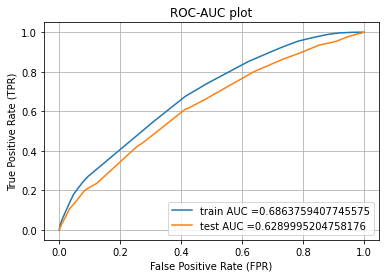

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier

clf_Dtree = DecisionTreeClassifier(max_depth= 10, min_samples_split= 500)
#neigh = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
clf_Dtree.fit(x_train, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(clf_Dtree, x_train)    
y_test_pred = batch_predict(clf_Dtree, x_test)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC-AUC plot")
plt.grid()
plt.show()

the maximum value of tpr*(1-fpr) 0.39596226400455636 for threshold 0.87
Test confusion matrix


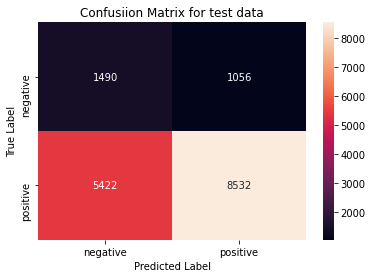

In [ ]:
print("="*100)
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Test confusion matrix")
Confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

In [ ]:
y_test_pred = predict_with_best_t(y_test_pred, best_t)
indices = []
for i in range(len(y_test)):
  if (y_test[i] == 0) and (y_test_pred[i] == 1):
    indices.append(iy[i])


df = [X_test['essay'][i] for i in indices]

new_x = X.iloc[indices]

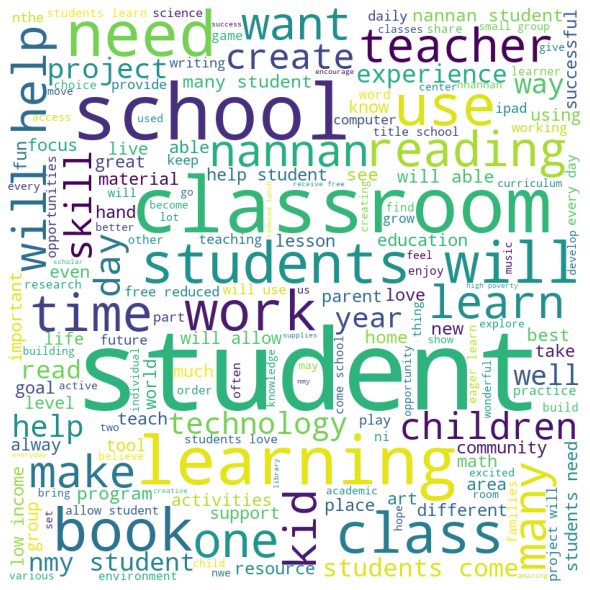

In [ ]:
#https://www.geeksforgeeks.org/generating-word-cloud-python/
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

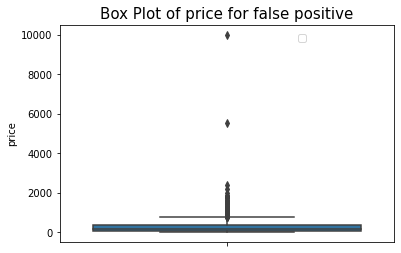

In [ ]:
import warnings
warnings.filterwarnings('ignore')
plt.title("Box Plot of price for false positive",fontsize=15)
ax=sns.boxplot(y='price', data=new_x)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper right', ncol=2, bbox_to_anchor=(.75, 0.98))
plt.show()

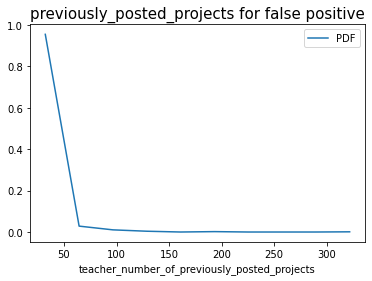

In [ ]:
counts, bin_edges = np.histogram(new_x['teacher_number_of_previously_posted_projects'], bins=10, 
                                 density = True)
pdf = counts/(sum(counts))
plt.plot(bin_edges[1:],pdf);
plt.xlabel('teacher_number_of_previously_posted_projects')
plt.title("previously_posted_projects for false positive",fontsize=15)
plt.legend(['PDF'])
plt.show();

##Summary

In [51]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyper parameter", "AUC"]

x.add_row(["TFIDF", "DecisionTree", "max_depth =  10, min_samples_split = 500", 0.620])
x.add_row(["TFIDF weighted W2V", "DecisionTree", "max_depth =  10, min_samples_split = 500", 0.591])
x.add_row(["TFIDF", "DecisionTree", "max_depth =  10, min_samples_split = 500", 0.628])

print(x)

+--------------------+--------------+------------------------------------------+-------+
|     Vectorizer     |    Model     |             Hyper parameter              |  AUC  |
+--------------------+--------------+------------------------------------------+-------+
|       TFIDF        | DecisionTree | max_depth =  10, min_samples_split = 500 |  0.62 |
| TFIDF weighted W2V | DecisionTree | max_depth =  10, min_samples_split = 500 | 0.591 |
|       TFIDF        | DecisionTree | max_depth =  10, min_samples_split = 500 | 0.628 |
+--------------------+--------------+------------------------------------------+-------+
